# Practice with TF 2.0 and Keras

## Classifier Objectives:
- (follow the [recipe](http://karpathy.github.io/2019/04/25/recipe/)!)
- ~~train a classifier~~
- use GPUs
- warm log to tensorboard
- warm log to mlflow
- train using TFRecords
- view ??? curves
- optimize thresholds
- fine-tune a classifier

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import cifar100
from tensorflow.keras import layers, models

## 1) Become one with the data

In [2]:
fine_labels_map = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus',
    'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch',
    'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
    'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark',
    'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',
    'wolf', 'woman', 'worm'
]

coarse_2_fine_mapping = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
    'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
}

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Input image shape:  (32, 32, 3)
Num training samples: 50000
Num test samples:     10000
Num labels:             100

Training Input:
  range: [0, 255]
  mean:   121.94
  median: 116.00
  standard deviation: 68.39
Test Input:
  range: [0, 255]
  mean:   122.24
  median: 117.00
  standard deviation: 68.63



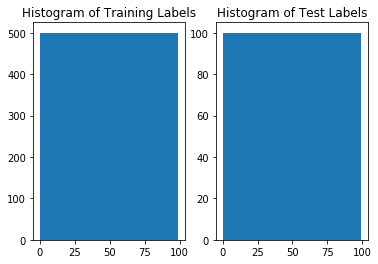

In [4]:
input_shape = x_train[0].shape
num_classes = len(fine_labels_map)

print("Input image shape:  {}".format(input_shape))
print("Num training samples: {}".format(x_train.shape[0]))
print("Num test samples:     {}".format(x_test.shape[0]))
print("Num labels:             {}".format(num_classes))
print()

print("Training Input:")
print("  range: [{}, {}]".format(np.min(x_train), np.max(x_train)))
print("  mean:   {:.2f}".format(np.mean(x_train)))
print("  median: {:.2f}".format(np.median(x_train)))
print("  standard deviation: {:.2f}".format(np.std(x_train)))
print("Test Input:")
print("  range: [{}, {}]".format(np.min(x_test), np.max(x_test)))
print("  mean:   {:.2f}".format(np.mean(x_test)))
print("  median: {:.2f}".format(np.median(x_test)))
print("  standard deviation: {:.2f}".format(np.std(x_test)))
print()

plt.subplot(121)
plt.hist(y_train, bins=num_classes)
plt.title("Histogram of Training Labels")

plt.subplot(122)
plt.hist(y_test, bins=num_classes);
plt.title("Histogram of Test Labels");

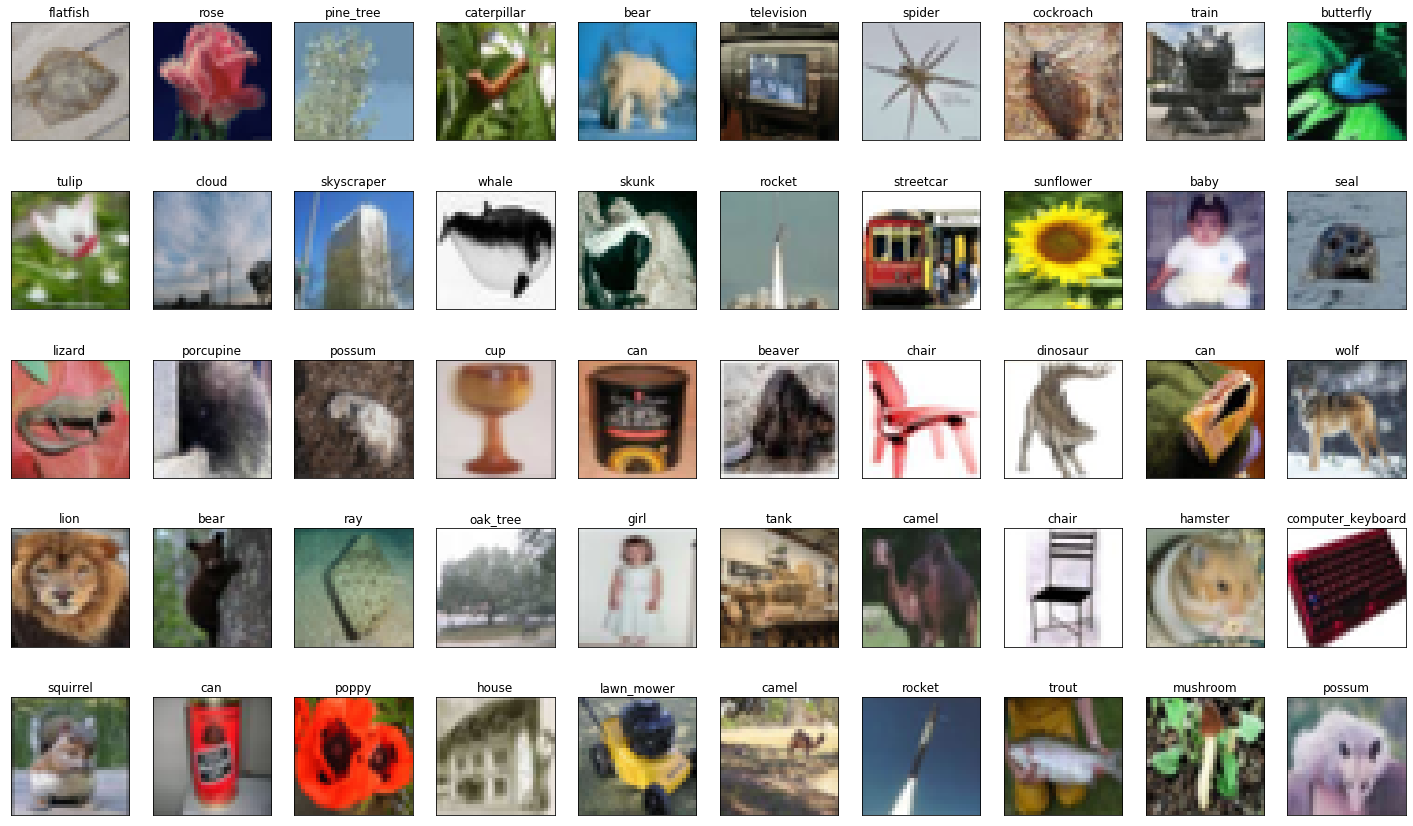

In [5]:
NUM_ROWS = 5
NUM_COLS = 10

fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(25, 15))

for i in range(NUM_ROWS):
    for j in range(NUM_COLS):
        # select a random sample        
        IDX = random.randint(0, x_train.shape[0])
        
        ax = axes[i, j]
        ax.imshow(x_train[IDX])
        ax.set_title(fine_labels_map[int(y_train[IDX])])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 2. Set up the end-to-end training/evaluation skeleton + get dumb baselines

In [6]:
# normalize the input data
x_train_normalized = x_train / 255.
x_test_normalized = x_test / 255.

# convert the labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

print("Train label shape: {}".format(y_train_cat.shape))
print("Test label shape:  {}".format(y_test_cat.shape))

Train label shape: (50000, 100)
Test label shape:  (10000, 100)


### Fully-Connected Network

In [7]:
fc_model = models.Sequential()
fc_model.add(layers.Dense(512, activation="relu", input_shape=(np.prod(input_shape),)))
fc_model.add(layers.Dense(num_classes, activation="relu"))

fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
Total params: 1,624,676
Trainable params: 1,624,676
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile model
fc_model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# flatten the input data
x_train_flat = x_train.reshape(x_train_normalized.shape[0], -1)
x_test_flat = x_test.reshape(x_test_normalized.shape[0], -1)

print("Train input shape: {}".format(x_train_flat.shape))
print("Test input shape:  {}".format(x_test_flat.shape))

Train input shape: (50000, 3072)
Test input shape:  (10000, 3072)


In [9]:
# train!
fc_model.fit(x_train_flat, y_train_cat, epochs=6, batch_size=128);

Train on 50000 samples
Epoch 1/6
50000/50000 [==============================] - 3s 68us/sample - loss: 10.0807 - accuracy: 0.0257
Epoch 2/6
50000/50000 [==============================] - 3s 59us/sample - loss: 9.8540 - accuracy: 0.0426
Epoch 3/6
50000/50000 [==============================] - 3s 60us/sample - loss: 9.8598 - accuracy: 0.0486
Epoch 4/6
50000/50000 [==============================] - 3s 60us/sample - loss: 9.8011 - accuracy: 0.0527
Epoch 5/6
50000/50000 [==============================] - 3s 61us/sample - loss: nan - accuracy: 0.0221
Epoch 6/6
50000/50000 [==============================] - 3s 63us/sample - loss: nan - accuracy: 0.0100


In [10]:
test_loss, test_acc = fc_model.evaluate(x_test_flat, y_test_cat, verbose=0)
print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.0100


### Convolutional Network

In [11]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation="relu"))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation="relu"))

conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________
